# Notebook 3: Student Model Training (Distillation + Adversarial) - EDITED
Purpose:
1. Load pre-processed original and augmented AG News data.
2. **Split combined data into Train/Validation (Rule Compliant).**
3. Apply token masking augmentation to the training split.
4. Calculate class weights for the training split.
5. Load roberta-base student model + LoRA config.
6. Load **fine-tuned LoRA roberta-large TEACHER model**.
7. Configure and use a DistillationTrainer (Weighted CE + FGM Adversarial + Distillation Loss).
8. Train the student model on GPU, validating on the created validation split.
9. Evaluate, save the best student model adapter, visualize, and generate submission.

In [73]:
# Clear working directory for clean run
# !rm -rf /kaggle/working/*

In [74]:
# --- Essential Imports ---
import os
import time
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import traceback
import random
import shutil
import gc
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

from datasets import load_dataset, Dataset, ClassLabel, load_from_disk, concatenate_datasets, Features, Value
from transformers import (
    AutoTokenizer,                
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,                      
    DataCollatorWithPadding,
    TrainerCallback,
    SchedulerType,
    TrainerState,
    TrainerControl
)
from peft import LoraConfig, get_peft_model, PeftModel, TaskType 
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

print("Setting up environment...")

# --- Cache Directory Setup ---
cache_dir = "/kaggle/working/hf_datasets_cache"
os.environ['HF_DATASETS_CACHE'] = cache_dir
os.environ['DATASETS_CACHE'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)
print(f"INFO: Hugging Face datasets cache directory set to: {os.environ.get('HF_DATASETS_CACHE')}")

Setting up environment...
INFO: Hugging Face datasets cache directory set to: /kaggle/working/hf_datasets_cache


In [75]:
# --- Configuration ---
student_base_model_name = 'roberta-base'
teacher_base_model_name = 'roberta-large'
dataset_name = 'ag_news'

# --- Paths ---
cleaned_original_load_path = "/kaggle/input/cleanedorig"
tokenized_augmented_load_path = "/kaggle/input/cleanedaugmenteddata" 
# *** Path to the uploaded TEACHER LoRA adapter directory ***
TEACHER_ADAPTER_PATH = "/kaggle/input/teacherrobertalarge/transformers/1/1" 

# Output paths for the STUDENT model
output_dir_student = "/kaggle/working/results_student_distill" 
final_student_model_save_path = "/kaggle/working/agnews_best_student_distill_3" 

# --- Student LoRA settings ---
LORA_R = 2
LORA_ALPHA = 4
LORA_DROPOUT = 0.05 
LORA_TARGET_MODULES = ['query']

# --- Adversarial settings for Student ---
ADVERSARIAL_EPSILON = 1.5 

# --- Distillation settings ---
DISTILLATION_ALPHA = 0.5 
DISTILLATION_TEMP = 2.0  

# --- Masking settings ---
MASKING_PROBABILITY = 0.20 

# --- Tokenizer settings ---
TOKENIZER_MAX_LENGTH = 512

# --- Validation Split Size ---
VALIDATION_SET_SIZE = 0.1 # Use 10% of combined train+aug for validation

In [76]:
# --- GPU Check ---
if torch.cuda.is_available(): device = torch.device("cuda"); print(f"GPU available: {torch.cuda.get_device_name(0)}")
else: device = torch.device("cpu"); print("WARNING: GPU not available.")

GPU available: Tesla P100-PCIE-16GB


In [77]:
# --- Load Tokenizer ---
print(f"Loading tokenizer for student: {student_base_model_name}")
try:
    tokenizer = AutoTokenizer.from_pretrained(student_base_model_name)
    # Define mask/pad tokens
    MASK_TOKEN_ID = tokenizer.mask_token_id
    PAD_TOKEN_ID = tokenizer.pad_token_id
    CLS_TOKEN_ID = tokenizer.cls_token_id
    SEP_TOKEN_ID = tokenizer.sep_token_id
except Exception as e: print(f"ERROR: Failed to load tokenizer: {e}"); raise e

Loading tokenizer for student: roberta-base


In [78]:
# --- Label Info ---
num_labels = 4; id2label = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
label2id = {v: k for k, v in id2label.items()}; class_names = list(id2label.values())
labels_feature_definition = ClassLabel(num_classes=num_labels, names=class_names)

In [79]:
# --- Load CLEANED ORIGINAL data ---
print(f"INFO: Attempting to load CLEANED ORIGINAL data from: {cleaned_original_load_path}")
original_ds_reloaded = None
if os.path.exists(cleaned_original_load_path):
    try:
        loaded_cleaned_original_ds_input = load_from_disk(cleaned_original_load_path)
        print(f"INFO: Loaded original data from input ({len(loaded_cleaned_original_ds_input)} examples).")

        # --- WORKAROUND START for Original Data ---
        temp_orig_save_path = "/kaggle/working/original_dataset_temp"
        print(f"INFO: Saving original dataset temporarily to {temp_orig_save_path}...")
        loaded_cleaned_original_ds_input.save_to_disk(temp_orig_save_path)
        original_features_ref = loaded_cleaned_original_ds_input.features # Save features before deleting
        del loaded_cleaned_original_ds_input
        gc.collect(); torch.cuda.empty_cache()
        print("INFO: Reloading original dataset from writable path...")
        original_ds_reloaded = load_from_disk(temp_orig_save_path)
        # Restore features if necessary
        if original_ds_reloaded.features != original_features_ref:
             print("INFO: Re-applying original features to reloaded dataset...")
             original_ds_reloaded = original_ds_reloaded.cast(original_features_ref)
        print("INFO: Original dataset reloaded successfully from /kaggle/working.")
        try:
             print(f"INFO: Removing temporary original save directory: {temp_orig_save_path}")
             shutil.rmtree(temp_orig_save_path)
        except Exception as e_rm: print(f"WARNING: Could not remove {temp_orig_save_path}: {e_rm}")
        # --- WORKAROUND END for Original Data ---

        # Get the label feature info from the reloaded dataset
        if 'labels' in original_ds_reloaded.features and isinstance(original_ds_reloaded.features['labels'], ClassLabel):
             original_labels_feature = original_ds_reloaded.features['labels']
             if original_labels_feature.num_classes != num_labels or original_labels_feature.names != class_names: 
                  print("Warning: Loaded original label feature mismatch. Re-casting.")
                  original_ds_reloaded = original_ds_reloaded.cast_column('labels', labels_feature_definition); original_labels_feature = original_ds_reloaded.features['labels']
             print(f"INFO: Extracted ClassLabel features: {original_labels_feature}")
        else: raise ValueError("Reloaded original dataset missing ClassLabel feature.")

    except Exception as e: print(f"ERROR loading/processing original: {e}"); raise e
else: raise FileNotFoundError(f"Path not found: {cleaned_original_load_path}")


# --- Load TOKENIZED AUGMENTED data ---
print(f"\nINFO: Attempting to load TOKENIZED AUGMENTED data from: {tokenized_augmented_load_path}")
augmented_ds_reloaded = None # Define outside try
if os.path.exists(tokenized_augmented_load_path):
     try:
         loaded_tokenized_augmented_ds_input = load_from_disk(tokenized_augmented_load_path)
         print(f"INFO: Loaded augmented data from input ({len(loaded_tokenized_augmented_ds_input)} examples).")

         temp_aug_save_path = "/kaggle/working/augmented_dataset_temp"
         print(f"INFO: Saving augmented dataset temporarily to {temp_aug_save_path}...")
         loaded_tokenized_augmented_ds_input.save_to_disk(temp_aug_save_path)
         augmented_features_ref = loaded_tokenized_augmented_ds_input.features
         del loaded_tokenized_augmented_ds_input
         gc.collect(); torch.cuda.empty_cache()
         print("INFO: Reloading augmented dataset from writable path...")
         augmented_ds_reloaded = load_from_disk(temp_aug_save_path)
         if augmented_ds_reloaded.features != augmented_features_ref:
              print("INFO: Re-applying augmented features to reloaded dataset...")
              augmented_ds_reloaded = augmented_ds_reloaded.cast(augmented_features_ref)
         print("INFO: Augmented dataset reloaded successfully from /kaggle/working.")
         try:
              print(f"INFO: Removing temporary augmented save directory: {temp_aug_save_path}")
              shutil.rmtree(temp_aug_save_path)
         except Exception as e_rm: print(f"WARNING: Could not remove {temp_aug_save_path}: {e_rm}")

         # Verify/cast labels using the original_labels_feature from the reloaded original DS
         # Use the reloaded variable here:
         if augmented_ds_reloaded.features['labels'] != original_labels_feature:
             print("WARNING: Reloaded augmented dataset labels feature mismatch! Casting...")
             augmented_ds_reloaded = augmented_ds_reloaded.cast_column('labels', original_labels_feature)

     except Exception as e: print(f"ERROR loading/processing augmented: {e}"); raise e
else: raise FileNotFoundError(f"Path not found: {tokenized_augmented_load_path}")

INFO: Attempting to load CLEANED ORIGINAL data from: /kaggle/input/cleanedorig
INFO: Loaded original data from input (114832 examples).
INFO: Saving original dataset temporarily to /kaggle/working/original_dataset_temp...


Saving the dataset (0/1 shards):   0%|          | 0/114832 [00:00<?, ? examples/s]

INFO: Reloading original dataset from writable path...
INFO: Original dataset reloaded successfully from /kaggle/working.
INFO: Removing temporary original save directory: /kaggle/working/original_dataset_temp
INFO: Extracted ClassLabel features: ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)

INFO: Attempting to load TOKENIZED AUGMENTED data from: /kaggle/input/cleanedaugmenteddata
INFO: Loaded augmented data from input (114832 examples).
INFO: Saving augmented dataset temporarily to /kaggle/working/augmented_dataset_temp...


Saving the dataset (0/1 shards):   0%|          | 0/114832 [00:00<?, ? examples/s]

INFO: Reloading augmented dataset from writable path...
INFO: Augmented dataset reloaded successfully from /kaggle/working.
INFO: Removing temporary augmented save directory: /kaggle/working/augmented_dataset_temp


In [80]:
# --- Combine Original + Augmented Data (Using Reloaded Objects) ---
print("\nINFO: Combining RELOADED original and RELOADED augmented datasets...")
required_columns = ['input_ids', 'attention_mask', 'labels']
try:
    train_dataset_for_concat = original_ds_reloaded.select_columns(required_columns)
    tokenized_augmented_dataset_for_concat = augmented_ds_reloaded.select_columns(required_columns)
except Exception as e:
    print(f"ERROR during column selection/prep for concat: {e}")
    raise e

combined_dataset_all = concatenate_datasets([train_dataset_for_concat, tokenized_augmented_dataset_for_concat])
print(f"Combined dataset created (Orig+Aug) with {len(combined_dataset_all)} examples.")

# Clean up intermediate objects
del train_dataset_for_concat, tokenized_augmented_dataset_for_concat, original_ds_reloaded, augmented_ds_reloaded
gc.collect(); torch.cuda.empty_cache()
print("Intermediate loaded datasets cleaned up.")


INFO: Combining RELOADED original and RELOADED augmented datasets...
Combined dataset created (Orig+Aug) with 229664 examples.
Intermediate loaded datasets cleaned up.


In [81]:
def random_token_masking(examples):
    all_input_ids = examples['input_ids']; new_input_ids = []
    for input_ids_list in all_input_ids:
        input_ids = list(input_ids_list); len_ids = len(input_ids)
        for i in range(len_ids):
            if input_ids[i] in [PAD_TOKEN_ID, CLS_TOKEN_ID, SEP_TOKEN_ID, MASK_TOKEN_ID]: continue
            if random.random() < MASKING_PROBABILITY: input_ids[i] = MASK_TOKEN_ID
        new_input_ids.append(input_ids)
    examples['input_ids'] = new_input_ids
    return examples


In [82]:
# --- Create Train/Validation Split from Combined Data ---
print(f"INFO: Splitting combined data into Train/Validation ({1.0-VALIDATION_SET_SIZE:.0%}/{VALIDATION_SET_SIZE:.0%})...")
# Ensure 'combined_dataset_all' (Orig+Aug) exists from the previous cell
if 'combined_dataset_all' not in locals():
    raise NameError("combined_dataset_all not found. Check previous cell.")

combined_dataset_shuffled = combined_dataset_all.shuffle(seed=42)
split_datasets = combined_dataset_shuffled.train_test_split(
    test_size=VALIDATION_SET_SIZE,
    seed=42,
    shuffle=False # Already shuffled
)

train_dataset_split = split_datasets['train']
eval_dataset_split = split_datasets['test']

print(f"Train split size: {len(train_dataset_split)}")
print(f"Validation split size: {len(eval_dataset_split)}")

# Clean up intermediate objects
del combined_dataset_all, combined_dataset_shuffled, split_datasets
gc.collect(); torch.cuda.empty_cache()


# --- Apply Masking ONLY to the Training Split ---
print(f"INFO: Applying random token masking to the TRAINING split (probability {MASKING_PROBABILITY})...")

# Apply the masking function defined earlier to the training split
train_dataset_masked = train_dataset_split.map(
    random_token_masking,
    batched=True,
)
print("INFO: Random token masking applied to training data.")

# --- Define final datasets for Trainer ---
train_dataset_for_final_run = train_dataset_masked
eval_dataset_for_final_run = eval_dataset_split

print(f"Final training dataset features: {train_dataset_for_final_run.features}")
print(f"Final validation dataset features: {eval_dataset_for_final_run.features}")


# Clean up intermediate dataset objects
del train_dataset_split, train_dataset_masked
gc.collect(); torch.cuda.empty_cache()

INFO: Splitting combined data into Train/Validation (90%/10%)...
Train split size: 206697
Validation split size: 22967
INFO: Applying random token masking to the TRAINING split (probability 0.2)...


Map:   0%|          | 0/206697 [00:00<?, ? examples/s]

INFO: Random token masking applied to training data.
Final training dataset features: {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}
Final validation dataset features: {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}


In [83]:
# --- Calculate Class Weights for the definitive Training Split ---
print("Calculating class weights for the training dataset...")
all_labels_final = np.array(train_dataset_for_final_run['labels'])
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels_final), y=all_labels_final)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print(f"Training class weights: {class_weights_tensor}")

Calculating class weights for the training dataset...
Training class weights: tensor([1.0199, 0.9616, 1.0183, 1.0024])


In [84]:
# --- Load Fine-tuned TEACHER Model (LoRA roberta-large) ---
print(f"--- Loading Teacher Model ({teacher_base_model_name} + LoRA) ---")
teacher_model = None
if os.path.exists(TEACHER_ADAPTER_PATH):
    try:
        print(f"Loading teacher base model: {teacher_base_model_name}")
        teacher_config = AutoConfig.from_pretrained(teacher_base_model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
        teacher_base_model = AutoModelForSequenceClassification.from_pretrained(teacher_base_model_name, config=teacher_config)

        print(f"Loading teacher LoRA adapter from: {TEACHER_ADAPTER_PATH}")
        # Load the PEFT adapter onto the base model
        teacher_model = PeftModel.from_pretrained(teacher_base_model, TEACHER_ADAPTER_PATH)

        teacher_model.to(device)
        teacher_model.eval()
        for param in teacher_model.parameters(): # Freeze teacher
            param.requires_grad = False
        print("Teacher model loaded, frozen, and set to eval mode.")
        gc.collect(); torch.cuda.empty_cache()
    except Exception as e:
        print(f"ERROR loading teacher model: {e}. Distillation will be disabled.")
        teacher_model = None
        traceback.print_exc()
else:
    print(f"WARNING: Teacher model path not found: {TEACHER_ADAPTER_PATH}. Distillation will be disabled.")

--- Loading Teacher Model (roberta-large + LoRA) ---
Loading teacher base model: roberta-large


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading teacher LoRA adapter from: /kaggle/input/teacherrobertalarge/transformers/1/1
Teacher model loaded, frozen, and set to eval mode.


In [85]:
# --- Prepare STUDENT Model (roberta-base + LoRA) ---
print(f"Initializing STUDENT model: {student_base_model_name} + LoRA")
student_base_model = AutoModelForSequenceClassification.from_pretrained(
    student_base_model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
print(f"Applying STUDENT LoRA config: r={LORA_R}, alpha={LORA_ALPHA}, dropout={LORA_DROPOUT}, targets={LORA_TARGET_MODULES}")
student_lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT
)
student_model = get_peft_model(student_base_model, student_lora_config)
print("Student LoRA model prepared.")
student_model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing STUDENT model: roberta-base + LoRA
Applying STUDENT LoRA config: r=2, alpha=4, dropout=0.05, targets=['query']
Student LoRA model prepared.
trainable params: 630,532 || all params: 125,279,240 || trainable%: 0.5033


In [86]:
# --- Define DistillationTrainer --- #
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, class_weights=None,
                 distillation_alpha=0.5, distillation_temp=2.0, adversarial_epsilon=0.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.class_weights = class_weights
        self.distillation_alpha = distillation_alpha
        self.distillation_temp = distillation_temp
        self.adversarial_epsilon = adversarial_epsilon 

        if self.teacher_model is not None:
            self._move_model_to_device(self.teacher_model, self.args.device)
            self.teacher_model.eval()
            print(f"DistillationTrainer: Teacher ready on device {self.teacher_model.device}")
        else: print("DistillationTrainer: No Teacher model.")
        if self.class_weights is not None: print(f"DistillationTrainer: Using class weights.")
        print(f"DistillationTrainer: alpha={self.distillation_alpha}, temp={self.distillation_temp}, adv_eps={self.adversarial_epsilon}")

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # `model` is the STUDENT model being trained
        labels = inputs.pop("labels").clone() if "labels" in inputs else None
        if labels is None: raise ValueError("Labels are required.")

        # --- Student Forward Pass (for hard loss and student logits) ---
        outputs_student = model(**inputs)
        logits_student = outputs_student.logits

        # --- Calculate Hard Loss (Weighted CE + FGM Adversarial) ---
        loss_weights = self.class_weights.to(logits_student.device) if self.class_weights is not None else None
        loss_fct = torch.nn.CrossEntropyLoss(weight=loss_weights)
        original_loss_student = loss_fct(logits_student.view(-1, model.config.num_labels), labels.view(-1))

        hard_loss = original_loss_student
        adv_loss_student = torch.tensor(0.0).to(self.args.device)

        if self.is_in_train and self.adversarial_epsilon > 0:
            try: # --- FGM Logic (Using autograd.grad for robustness) ---
                input_ids = inputs.get("input_ids")
                embedding_layer = model.get_input_embeddings()
                original_embeddings = embedding_layer(input_ids)
                original_embeddings_detached = original_embeddings.detach().clone()
                embeds_for_grad = original_embeddings_detached.clone().requires_grad_(True)
                temp_inputs = inputs.copy(); temp_inputs["inputs_embeds"] = embeds_for_grad; temp_inputs["input_ids"] = None
                with torch.enable_grad():
                    # Need a forward pass here to compute gradients w.r.t embeds_for_grad
                    # This uses the *student* model to calculate the gradient direction
                    temp_outputs = model(**temp_inputs)
                    temp_logits = temp_outputs.logits
                    # Use the same weighted loss for gradient calculation
                    temp_loss = loss_fct(temp_logits.view(-1, model.config.num_labels), labels.view(-1))
                embed_grads = torch.autograd.grad(temp_loss, embeds_for_grad, retain_graph=False, create_graph=False)[0]
                if embed_grads is None: raise RuntimeError("FGM grad failed using autograd.grad.")
                # --- Calculate Perturbation ---
                norm = torch.norm(embed_grads, p=2, dim=-1, keepdim=True) + 1e-8
                delta = embed_grads / norm
                perturbation = self.adversarial_epsilon * delta
                # --- Adversarial Forward Pass (Student) ---
                perturbed_embeddings = original_embeddings_detached + perturbation
                adv_inputs = inputs.copy(); adv_inputs["inputs_embeds"] = perturbed_embeddings; adv_inputs["input_ids"] = None
                adv_outputs = model(**adv_inputs); adv_logits = adv_outputs.logits
                adv_loss_student = loss_fct(adv_logits.view(-1, model.config.num_labels), labels.view(-1))
                # --- Update Hard Loss ---
                hard_loss = original_loss_student + adv_loss_student # Add adversarial loss
            except Exception as e:
                print(f"WARNING: FGM step failed: {e}. Using original loss only for hard component.")
                hard_loss = original_loss_student # Fallback

        # --- Distillation Loss ---
        loss_distill = torch.tensor(0.0).to(self.args.device)
        if self.teacher_model is not None and self.is_in_train:
            with torch.no_grad(): # Teacher inference without gradients
                teacher_inputs = inputs.copy()
                outputs_teacher = self.teacher_model(**teacher_inputs)
                logits_teacher = outputs_teacher.logits.detach()

            loss_distill = F.kl_div(
                F.log_softmax(logits_student / self.distillation_temp, dim=-1),
                F.softmax(logits_teacher / self.distillation_temp, dim=-1),
                reduction='batchmean'
            ) * (self.distillation_temp ** 2)

        # --- Combine Losses ---
        total_loss = (self.distillation_alpha * hard_loss) + ((1.0 - self.distillation_alpha) * loss_distill)

        # Add labels back
        inputs["labels"] = labels
        return (total_loss, outputs_student) if return_outputs else total_loss
# --- End Distillation Trainer Class ---

In [87]:
# --- Define Metrics, Collator, Callbacks ---
def compute_metrics(eval_preds): logits, labels = eval_preds; predictions = np.argmax(logits, axis=-1); acc = accuracy_score(labels, predictions); f1 = f1_score(labels, predictions, average='weighted'); return {"accuracy": acc, "f1": f1}
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
class MetricsCollectorCallback(TrainerCallback):
    def __init__(self): self.logs = []
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None: self.logs.append((state.global_step, logs))
        return control
metrics_collector = MetricsCollectorCallback()

In [88]:
# --- Define FINAL Training Arguments for Student ---
print("Defining Final Training Arguments for Student Distillation...")
training_args = TrainingArguments(
    output_dir=output_dir_student,
    eval_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2, # Keep best 2 student checkpoints

    # --- Parameters ---
    learning_rate=6.5e-5,
    lr_scheduler_type=SchedulerType.COSINE,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2, # Effective batch = 16*2=32
    num_train_epochs=1,
    weight_decay=0.1,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to=[],
    logging_first_step=True,
    logging_dir=f"{output_dir_student}/logs"
)

Defining Final Training Arguments for Student Distillation...


In [89]:
# --- Initialize Distillation Trainer ---
print("Initializing Distillation Trainer for Student Model...")
if 'class_weights_tensor' not in locals(): class_weights_tensor = None
if 'train_dataset_for_final_run' not in locals(): raise NameError("Final training dataset not defined.")
if 'teacher_model' not in locals(): raise NameError("Teacher model not loaded/defined.")
if 'student_model' not in locals(): raise NameError("Student model not initialized.")

trainer = DistillationTrainer(
    model=student_model,               # STUDENT PeftModel
    teacher_model=teacher_model,       # Loaded LoRA Teacher
    args=training_args,
    distillation_alpha=DISTILLATION_ALPHA,
    distillation_temp=DISTILLATION_TEMP,
    adversarial_epsilon=ADVERSARIAL_EPSILON,
    class_weights=class_weights_tensor, # Pass calculated weights
    data_collator=data_collator,
    train_dataset=train_dataset_for_final_run, # Final masked training data (Orig+Aug)
    eval_dataset=eval_dataset_for_final_run,                 # Validation split from train data
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[metrics_collector],            
)
print("Distillation Trainer initialized.")

/tmp/ipykernel_31/1762601069.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Initializing Distillation Trainer for Student Model...


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


DistillationTrainer: Teacher ready on device cuda:0
DistillationTrainer: Using class weights.
DistillationTrainer: alpha=0.5, temp=2.0, adv_eps=1.5
Distillation Trainer initialized.


In [90]:
# --- Train the Student Model ---
import torch.serialization; import numpy.core.multiarray
try: from numpy.dtypes import UInt32DType
except ImportError: UInt32DType = None
safe_numpy_globals = []; print("Attempting NumPy allowlist...")
try:
    safe_numpy_globals.append(np.core.multiarray._reconstruct)
    safe_numpy_globals.append(np.ndarray); safe_numpy_globals.append(np.dtype)
    if UInt32DType: safe_numpy_globals.append(UInt32DType)
    else: safe_numpy_globals.append(np.uint32)
    safe_numpy_globals = list(set(safe_numpy_globals))
    torch.serialization.add_safe_globals(safe_numpy_globals)
    print(f"Added NumPy components: {[c.__name__ if hasattr(c, '__name__') else str(c) for c in safe_numpy_globals]}")
except Exception as e_gen: print(f"WARNING: Error setting safe globals for numpy: {e_gen}")


print("Starting Student Model Training with Distillation...")
start_train_time = time.time()
try:
    # Train fresh student model
    train_result = trainer.train(resume_from_checkpoint=None)
    print("Student training finished.")
    metrics = train_result.metrics
    print("--- Student Training Metrics ---")
    for key, value in metrics.items(): print(f"{key}: {value}")
    trainer.save_metrics("train", metrics)
except Exception as e: print(f"ERROR during student training: {e}"); traceback.print_exc(); raise e
end_train_time = time.time()
print(f"Student Training Duration: {end_train_time - start_train_time:.2f} seconds")

Attempting NumPy allowlist...
Added NumPy components: ['_reconstruct', 'UInt32DType', 'ndarray', 'dtype']
Starting Student Model Training with Distillation...


Step,Training Loss,Validation Loss,Accuracy,F1
500,1.934700,1.780804,0.884356,0.882081
1000,0.907100,0.842550,0.925632,0.925381
1500,0.828700,0.764826,0.929464,0.929214
2000,0.779800,0.718939,0.931772,0.931551
2500,0.739500,0.689612,0.935081,0.934953
3000,0.730500,0.667282,0.935865,0.935718
3500,0.694200,0.652919,0.936518,0.936392
4000,0.678900,0.644869,0.937824,0.937702
4500,0.683500,0.635481,0.937780,0.937638
5000,0.665800,0.631356,0.938129,0.938011


Student training finished.
--- Student Training Metrics ---
train_runtime: 13408.5375
train_samples_per_second: 15.415
train_steps_per_second: 0.482
total_flos: 1.0032661656e+16
train_loss: 0.854914902496456
epoch: 0.9999225946280672
Student Training Duration: 13409.05 seconds


In [95]:
# --- Save the Final Student Model Adapter ---
print(f"\nSaving the best student model adapter identified during training to {final_student_model_save_path}...")
try:
    trainer.save_model(final_student_model_save_path) # Saves student adapter
    tokenizer.save_pretrained(final_student_model_save_path) # Save tokenizer
    final_args_path = os.path.join(final_student_model_save_path, "student_training_args.json")
    with open(final_args_path, 'w') as f: f.write(training_args.to_json_string())
    print(f"Best student adapter, tokenizer, and training args saved.")
except Exception as e: print(f"ERROR saving final student adapter: {e}")


Saving the best student model adapter identified during training to /kaggle/working/agnews_best_student_distill_3...
Best student adapter, tokenizer, and training args saved.


In [92]:
# --- Evaluate Student on Validation Set ---
print("\nRunning final evaluation on the validation set for the Student Model...")
try:
    eval_metrics = trainer.evaluate(eval_dataset=eval_dataset_for_final_run)
    print("--- Student Final Validation Metrics ---")
    for key, value in eval_metrics.items(): print(f"{key}: {value}")
    trainer.save_metrics("eval", eval_metrics)
except Exception as e: print(f"ERROR during final student evaluation: {e}")


Running final evaluation on the validation set for the Student Model...


--- Student Final Validation Metrics ---
eval_loss: 0.1039804145693779
eval_accuracy: 0.9383898637175078
eval_f1: 0.9382669087329296
eval_runtime: 83.7853
eval_samples_per_second: 274.117
eval_steps_per_second: 4.285
epoch: 0.9999225946280672



Plotting training history...


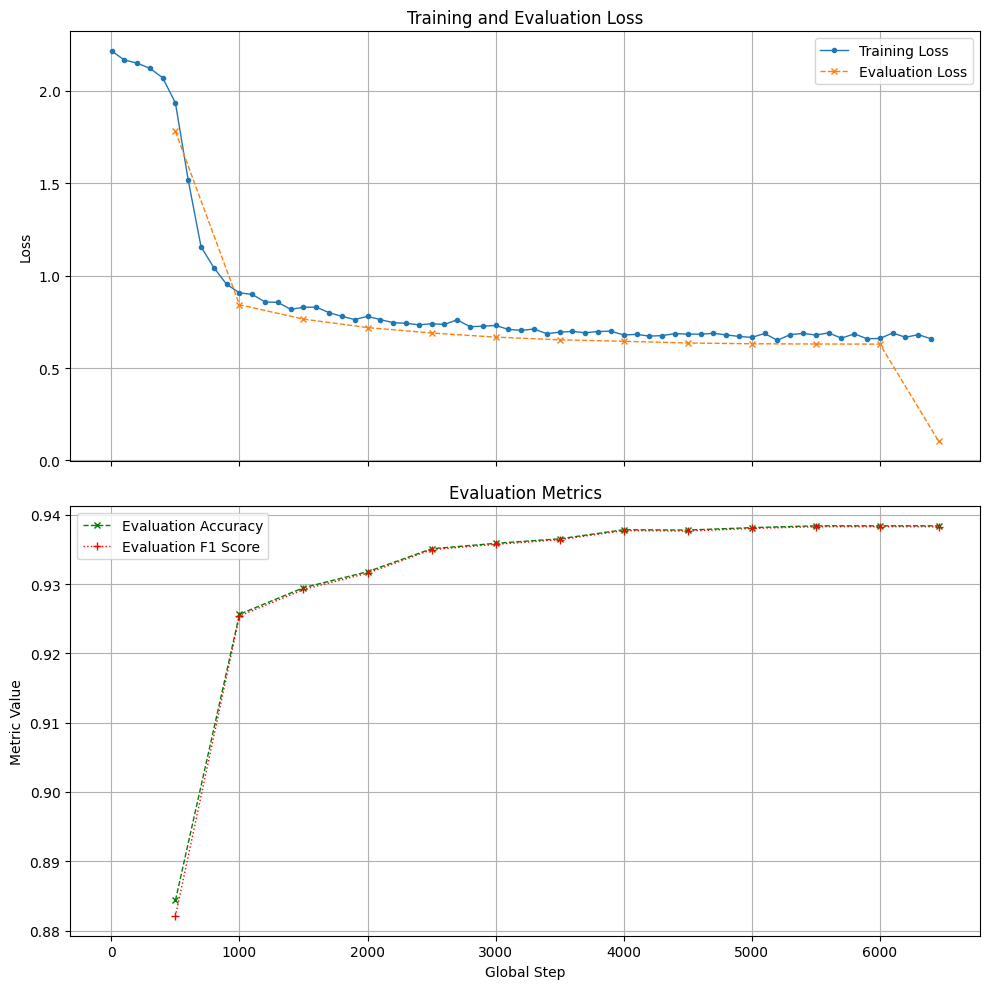

INFO: Plot saved to training_validation_metrics.png


In [93]:
# --- Plotting Training History ---
print("\nPlotting training history...")
try:
    train_steps, train_loss, eval_steps, eval_loss, eval_accuracy, eval_f1 = [], [], [], [], [], []
    for step, log in metrics_collector.logs:
        if "loss" in log and "eval_loss" not in log:
            train_steps.append(step)
            train_loss.append(log["loss"])
        elif "eval_loss" in log:
            eval_steps.append(step)
            eval_loss.append(log["eval_loss"])
            eval_accuracy.append(log.get("eval_accuracy", np.nan))
            eval_f1.append(log.get("eval_f1", np.nan))

    if not eval_steps:
         print("No evaluation logs found to plot.")
    else:
        fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
        # Loss Plot
        if train_steps: axs[0].plot(train_steps, train_loss, marker='o', linestyle='-', linewidth=1, markersize=3, label="Training Loss")
        axs[0].plot(eval_steps, eval_loss, marker='x', linestyle='--', linewidth=1, markersize=5, label="Evaluation Loss")
        axs[0].set_ylabel("Loss"); axs[0].set_title("Training and Evaluation Loss"); axs[0].legend(); axs[0].grid(True)
        # Accuracy / F1 Plot
        axs[1].plot(eval_steps, eval_accuracy, marker='x', linestyle='--', linewidth=1, markersize=5, label="Evaluation Accuracy", color='green')
        axs[1].plot(eval_steps, eval_f1, marker='+', linestyle=':', linewidth=1, markersize=6, label="Evaluation F1 Score", color='red')
        axs[1].set_xlabel("Global Step"); axs[1].set_ylabel("Metric Value"); axs[1].set_title("Evaluation Metrics"); axs[1].legend(); axs[1].grid(True)
        plt.tight_layout(); plt.show()
        fig.savefig("training_validation_metrics.png", dpi=300, bbox_inches='tight')
        print("INFO: Plot saved to training_validation_metrics.png")
except Exception as e:
    print(f"ERROR plotting metrics: {e}")
    traceback.print_exc()


Setting up for visualization...
Model config set to output hidden states.
Extracting CLS token embeddings for visualization...
Extracting embeddings using device: cuda:0
Extracted 300 embeddings.
Plotting t-SNE and UMAP...


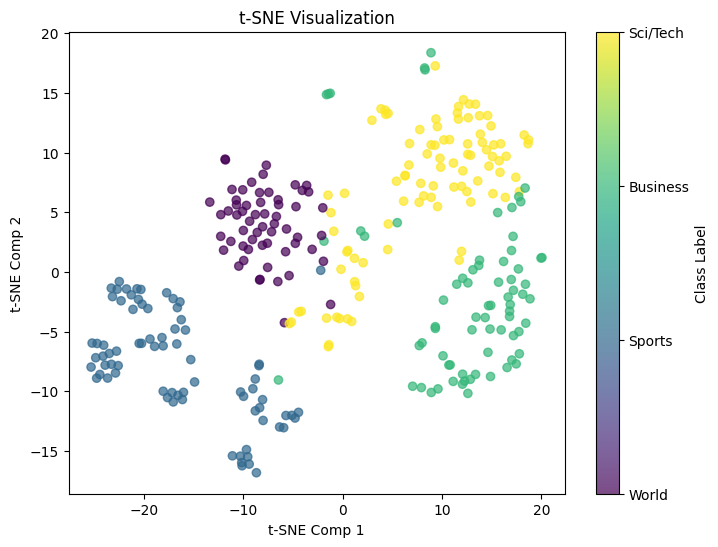

In [94]:
# --- t-SNE Visualization ---
print("\nSetting up for visualization...")
try:
    trainer.model.config.output_hidden_states = True
    print("Model config set to output hidden states.")
except Exception as e: print(f"ERROR setting output_hidden_states: {e}")

print("Extracting CLS token embeddings for visualization...")
subset_size = 300
if len(eval_dataset_for_final_run) < subset_size: subset_size = len(eval_dataset_for_final_run)
features = None; label_list = []
if subset_size > 0:
    try:
        subset_indices = random.sample(range(len(eval_dataset_for_final_run)), subset_size)
        subset = eval_dataset_for_final_run.select(subset_indices)
        feature_list = []
        model_device = trainer.model.device
        print(f"Extracting embeddings using device: {model_device}")
        for sample in subset:
            input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(model_device)
            attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0).to(model_device)
            with torch.no_grad(): outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)
            if hasattr(outputs, 'hidden_states') and outputs.hidden_states is not None:
                 hidden_state = outputs.hidden_states[-1]; cls_embedding = hidden_state[0, 0, :].cpu().numpy()
                 feature_list.append(cls_embedding); label_list.append(sample["labels"])
            else: print("WARNING: Could not get hidden_states for sample.")
        if feature_list: features = np.array(feature_list); print(f"Extracted {len(features)} embeddings.")
        else: print("WARNING: No features were extracted.")
    except Exception as e: print(f"ERROR extracting embeddings: {e}")
else: print("WARNING: Evaluation dataset too small, skipping visualization.")

print("Plotting t-SNE and UMAP...")
if features is not None and features.shape[0] > 1:
    try:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, features.shape[0] - 1))
        features_2d_tsne = tsne.fit_transform(features); plt.figure(figsize=(8, 6))
        scatter = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=label_list, cmap="viridis", alpha=0.7)
        cbar = plt.colorbar(scatter, label="Class Label", ticks=range(len(class_names))); cbar.ax.set_yticklabels(class_names)
        plt.title("t-SNE Visualization"); plt.xlabel("t-SNE Comp 1"); plt.ylabel("t-SNE Comp 2");
        plt.show()
    except Exception as e: print(f"ERROR in t-SNE: {e}")
else: print("Skipping plots (not enough features extracted).")